In [119]:
%matplotlib inline

import numpy as np

import torch
torch.set_default_dtype(torch.float64)

import matplotlib.pyplot as plt

#import time

from utils import make_kernels, density
from optim import accelerated_gd

from data_generator import generate_2d_data

## Sample data

In [120]:
n = 100
m = 50
dataset = 'moons'

X = generate_2d_data(dataset, rng=42, batch_size=n)[0]

## Subsample support points
torch.manual_seed(42)
Xn = torch.from_numpy(X).double()[torch.randperm(n)]
Xm = Xn[:m]


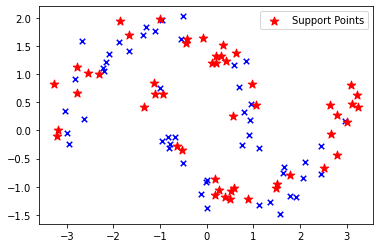

In [121]:
plt.scatter(Xn[m:, 0], Xn[m:, 1], marker='x', s = 30, color = 'blue')
plt.scatter(Xm[:, 0], Xm[:, 1], marker='*', s = 80, color ='red', label = 'Support Points')


plt.legend()

## Fit density 

In [122]:
### hyperparameters

sigma = np.sqrt(.5)
lbda = 1e-3

niter = 100000
tau = 1e-11

### build matrices
Kmm, Kmn, W, U = make_kernels(Xm, Xn, sigma=sigma)

In [123]:
B, losses  = accelerated_gd(U, W, Kmm, Kmn, lbda=lbda, reg='trace',
                                        tau=tau, niter=niter, acceleration=True, factored=True,
                                        verbose=True, report_interval=5000)

Largest eigenvalue = 5.7369e+00 obtained in 1.39e+00 seconds
iter 1:	loss: 2.14e-02
iter 1196:	loss: 2.212497e-03
Precision 1.00e-11 reached in 2.35e+00 seconds


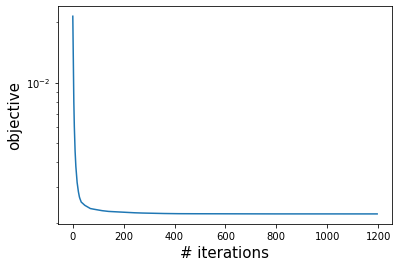

In [124]:
## Monitor loss decrease
plt.plot(losses)
plt.yscale('log')

plt.xlabel("# iterations", fontsize=15)
plt.ylabel("objective", fontsize=15)

plt.show()

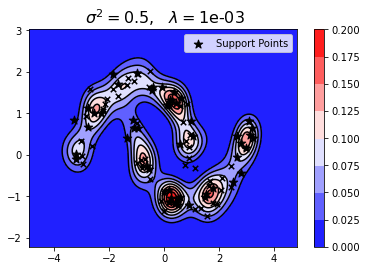

In [125]:
import scipy.stats

fig, ax = plt.subplots()


xmax = 1.5 * X[:, 0].max().item()
xmin = 1.5 * X[:, 0].min().item()

ymax = 1.5 * X[:, 1].max().item()
ymin = 1.5 * X[:, 1].min().item()


x, y = np.mgrid[xmin:xmax:.05, ymin:ymax:.05]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y


Z = density(torch.from_numpy(pos.reshape(-1, 2)), Xm, B, sigma).reshape(pos.shape[:-1])


CS = ax.contour(x, y, Z, colors= 'black')
CF = ax.contourf(x, y, Z, cmap = 'bwr')
cbar = plt.colorbar(CF)

ax.scatter(Xn[m:, 0], Xn[m:, 1], marker='x', s = 30, color ='black')
ax.scatter(Xm[:, 0], Xm[:, 1], marker='*', s = 80, color ='black', label = 'Support Points')


plt.title(rf" $\sigma^2 = ${sigma**2:.1f},   $\lambda = ${lbda:.0e}", fontsize=16)

plt.legend()

plt.savefig(f'../figs_arxiv/{dataset}_n_{n}_m_{m}_sigma_{sigma**2:.1f}_lambda_{lbda}_trace.pdf', bbox_inches='tight')
plt.savefig(f'../figs_arxiv/{dataset}_n_{n}_m_{m}_sigma_{sigma**2:.1f}_lambda_{lbda}_trace.png', bbox_inches='tight')

plt.show()